# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

2.1.0


## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [3]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [4]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [5]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [6]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [7]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 2ms/sample - loss: 235.6409 - y1_output_loss: 110.5095 - y2_output_loss: 123.1026 - y1_output_root_mean_squared_error: 10.5602 - y2_output_root_mean_squared_error: 11.1411 - val_loss: 32.6846 - val_y1_output_loss: 14.7843 - val_y2_output_loss: 17.5765 - val_y1_output_root_mean_squared_error: 3.8835 - val_y2_output_root_mean_squared_error: 4.1956
Epoch 2/500
614/614 [==============================] - 0s 273us/sample - loss: 31.6189 - y1_output_loss: 12.2112 - y2_output_loss: 19.3464 - y1_output_root_mean_squared_error: 3.4954 - y2_output_root_mean_squared_error: 4.4047 - val_loss: 45.0993 - val_y1_output_loss: 16.0504 - val_y2_output_loss: 27.6863 - val_y1_output_root_mean_squared_error: 4.0733 - val_y2_output_root_mean_squared_error: 5.3392
Epoch 3/500
614/614 [==============================] - 0s 286us/sample - loss: 24.8532 - y1_output_loss: 10.0165 - y2_output_loss: 14.8445 - y1_o

614/614 [==============================] - 0s 304us/sample - loss: 7.2403 - y1_output_loss: 2.3879 - y2_output_loss: 4.8447 - y1_output_root_mean_squared_error: 1.5417 - y2_output_root_mean_squared_error: 2.2053 - val_loss: 7.4916 - val_y1_output_loss: 2.1390 - val_y2_output_loss: 5.1074 - val_y1_output_root_mean_squared_error: 1.4848 - val_y2_output_root_mean_squared_error: 2.2994
Epoch 42/500
614/614 [==============================] - 0s 228us/sample - loss: 9.9802 - y1_output_loss: 3.2108 - y2_output_loss: 6.7478 - y1_output_root_mean_squared_error: 1.7944 - y2_output_root_mean_squared_error: 2.6001 - val_loss: 7.1488 - val_y1_output_loss: 2.3830 - val_y2_output_loss: 4.6573 - val_y1_output_root_mean_squared_error: 1.5384 - val_y2_output_root_mean_squared_error: 2.1868
Epoch 43/500
614/614 [==============================] - 0s 278us/sample - loss: 9.1806 - y1_output_loss: 2.6874 - y2_output_loss: 6.4495 - y1_output_root_mean_squared_error: 1.6450 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 249us/sample - loss: 4.6021 - y1_output_loss: 1.2116 - y2_output_loss: 3.3494 - y1_output_root_mean_squared_error: 1.1060 - y2_output_root_mean_squared_error: 1.8381 - val_loss: 4.6266 - val_y1_output_loss: 1.1640 - val_y2_output_loss: 3.3463 - val_y1_output_root_mean_squared_error: 1.0753 - val_y2_output_root_mean_squared_error: 1.8629
Epoch 63/500
614/614 [==============================] - 0s 256us/sample - loss: 4.3650 - y1_output_loss: 1.1131 - y2_output_loss: 3.2119 - y1_output_root_mean_squared_error: 1.0596 - y2_output_root_mean_squared_error: 1.8006 - val_loss: 4.5969 - val_y1_output_loss: 1.0826 - val_y2_output_loss: 3.3967 - val_y1_output_root_mean_squared_error: 1.0390 - val_y2_output_root_mean_squared_error: 1.8755
Epoch 64/500
614/614 [==============================] - 0s 292us/sample - loss: 4.0391 - y1_output_loss: 1.0135 - y2_output_loss: 3.0374 - y1_output_root_mean_squared_error: 1.0091 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 286us/sample - loss: 4.3180 - y1_output_loss: 0.9638 - y2_output_loss: 3.3594 - y1_output_root_mean_squared_error: 0.9845 - y2_output_root_mean_squared_error: 1.8300 - val_loss: 3.5929 - val_y1_output_loss: 0.7761 - val_y2_output_loss: 2.7826 - val_y1_output_root_mean_squared_error: 0.8482 - val_y2_output_root_mean_squared_error: 1.6951
Epoch 84/500
614/614 [==============================] - 0s 227us/sample - loss: 3.7349 - y1_output_loss: 0.7508 - y2_output_loss: 2.9643 - y1_output_root_mean_squared_error: 0.8702 - y2_output_root_mean_squared_error: 1.7256 - val_loss: 5.4190 - val_y1_output_loss: 0.7321 - val_y2_output_loss: 4.5619 - val_y1_output_root_mean_squared_error: 0.8662 - val_y2_output_root_mean_squared_error: 2.1607
Epoch 85/500
614/614 [==============================] - 0s 228us/sample - loss: 3.5404 - y1_output_loss: 0.7540 - y2_output_loss: 2.7810 - y1_output_root_mean_squared_error: 0.8713 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 318us/sample - loss: 3.0139 - y1_output_loss: 0.7363 - y2_output_loss: 2.2843 - y1_output_root_mean_squared_error: 0.8537 - y2_output_root_mean_squared_error: 1.5117 - val_loss: 5.1210 - val_y1_output_loss: 0.5625 - val_y2_output_loss: 4.4839 - val_y1_output_root_mean_squared_error: 0.7593 - val_y2_output_root_mean_squared_error: 2.1318
Epoch 105/500
614/614 [==============================] - 0s 256us/sample - loss: 4.5046 - y1_output_loss: 1.1543 - y2_output_loss: 3.3130 - y1_output_root_mean_squared_error: 1.0794 - y2_output_root_mean_squared_error: 1.8275 - val_loss: 2.9398 - val_y1_output_loss: 0.4507 - val_y2_output_loss: 2.3982 - val_y1_output_root_mean_squared_error: 0.6766 - val_y2_output_root_mean_squared_error: 1.5754
Epoch 106/500
614/614 [==============================] - 0s 253us/sample - loss: 3.0155 - y1_output_loss: 0.6493 - y2_output_loss: 2.3571 - y1_output_root_mean_squared_error: 0.8014 - y2_output_root_mea

Epoch 145/500
614/614 [==============================] - 0s 379us/sample - loss: 1.9944 - y1_output_loss: 0.4889 - y2_output_loss: 1.4911 - y1_output_root_mean_squared_error: 0.7001 - y2_output_root_mean_squared_error: 1.2265 - val_loss: 2.6622 - val_y1_output_loss: 0.4266 - val_y2_output_loss: 2.1842 - val_y1_output_root_mean_squared_error: 0.6623 - val_y2_output_root_mean_squared_error: 1.4911
Epoch 146/500
614/614 [==============================] - 0s 294us/sample - loss: 1.9389 - y1_output_loss: 0.4320 - y2_output_loss: 1.4926 - y1_output_root_mean_squared_error: 0.6575 - y2_output_root_mean_squared_error: 1.2274 - val_loss: 2.3439 - val_y1_output_loss: 0.3700 - val_y2_output_loss: 1.9009 - val_y1_output_root_mean_squared_error: 0.6092 - val_y2_output_root_mean_squared_error: 1.4045
Epoch 147/500
614/614 [==============================] - 0s 291us/sample - loss: 1.7898 - y1_output_loss: 0.3850 - y2_output_loss: 1.3957 - y1_output_root_mean_squared_error: 0.6225 - y2_output_root_mea

Epoch 186/500
614/614 [==============================] - 0s 285us/sample - loss: 1.5485 - y1_output_loss: 0.3277 - y2_output_loss: 1.2127 - y1_output_root_mean_squared_error: 0.5745 - y2_output_root_mean_squared_error: 1.1038 - val_loss: 2.2253 - val_y1_output_loss: 0.2847 - val_y2_output_loss: 1.9014 - val_y1_output_root_mean_squared_error: 0.5401 - val_y2_output_root_mean_squared_error: 1.3905
Epoch 187/500
614/614 [==============================] - 0s 215us/sample - loss: 1.3579 - y1_output_loss: 0.2570 - y2_output_loss: 1.1560 - y1_output_root_mean_squared_error: 0.5028 - y2_output_root_mean_squared_error: 1.0512 - val_loss: 13.9222 - val_y1_output_loss: 2.0226 - val_y2_output_loss: 11.8306 - val_y1_output_root_mean_squared_error: 1.3908 - val_y2_output_root_mean_squared_error: 3.4624
Epoch 188/500
614/614 [==============================] - 0s 252us/sample - loss: 1.7842 - y1_output_loss: 0.3685 - y2_output_loss: 1.4096 - y1_output_root_mean_squared_error: 0.6073 - y2_output_root_m

Epoch 227/500
614/614 [==============================] - 0s 251us/sample - loss: 1.3744 - y1_output_loss: 0.3162 - y2_output_loss: 1.0645 - y1_output_root_mean_squared_error: 0.5637 - y2_output_root_mean_squared_error: 1.0279 - val_loss: 4.3696 - val_y1_output_loss: 0.5118 - val_y2_output_loss: 3.7527 - val_y1_output_root_mean_squared_error: 0.7233 - val_y2_output_root_mean_squared_error: 1.9612
Epoch 228/500
614/614 [==============================] - 0s 346us/sample - loss: 1.3384 - y1_output_loss: 0.2155 - y2_output_loss: 1.1133 - y1_output_root_mean_squared_error: 0.4659 - y2_output_root_mean_squared_error: 1.0589 - val_loss: 1.5985 - val_y1_output_loss: 0.2282 - val_y2_output_loss: 1.3427 - val_y1_output_root_mean_squared_error: 0.4693 - val_y2_output_root_mean_squared_error: 1.1740
Epoch 229/500
614/614 [==============================] - 0s 300us/sample - loss: 1.0033 - y1_output_loss: 0.2048 - y2_output_loss: 0.7908 - y1_output_root_mean_squared_error: 0.4541 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 320us/sample - loss: 0.7374 - y1_output_loss: 0.1579 - y2_output_loss: 0.5729 - y1_output_root_mean_squared_error: 0.3990 - y2_output_root_mean_squared_error: 0.7604 - val_loss: 1.2604 - val_y1_output_loss: 0.2301 - val_y2_output_loss: 1.0084 - val_y1_output_root_mean_squared_error: 0.4658 - val_y2_output_root_mean_squared_error: 1.0215
Epoch 269/500
614/614 [==============================] - 0s 226us/sample - loss: 0.8737 - y1_output_loss: 0.2295 - y2_output_loss: 0.6470 - y1_output_root_mean_squared_error: 0.4766 - y2_output_root_mean_squared_error: 0.8041 - val_loss: 2.5879 - val_y1_output_loss: 0.8514 - val_y2_output_loss: 1.7264 - val_y1_output_root_mean_squared_error: 0.9044 - val_y2_output_root_mean_squared_error: 1.3304
Epoch 270/500
614/614 [==============================] - 0s 290us/sample - loss: 1.4808 - y1_output_loss: 0.3097 - y2_output_loss: 1.1604 - y1_output_root_mean_squared_error: 0.5587 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 322us/sample - loss: 0.6945 - y1_output_loss: 0.1475 - y2_output_loss: 0.5471 - y1_output_root_mean_squared_error: 0.3841 - y2_output_root_mean_squared_error: 0.7396 - val_loss: 1.7439 - val_y1_output_loss: 0.3123 - val_y2_output_loss: 1.3896 - val_y1_output_root_mean_squared_error: 0.5584 - val_y2_output_root_mean_squared_error: 1.1967
Epoch 310/500
614/614 [==============================] - 0s 347us/sample - loss: 0.6133 - y1_output_loss: 0.1607 - y2_output_loss: 0.4514 - y1_output_root_mean_squared_error: 0.4009 - y2_output_root_mean_squared_error: 0.6728 - val_loss: 1.4051 - val_y1_output_loss: 0.3470 - val_y2_output_loss: 1.0299 - val_y1_output_root_mean_squared_error: 0.5945 - val_y2_output_root_mean_squared_error: 1.0255
Epoch 311/500
614/614 [==============================] - 0s 350us/sample - loss: 0.6891 - y1_output_loss: 0.1581 - y2_output_loss: 0.5296 - y1_output_root_mean_squared_error: 0.3961 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 213us/sample - loss: 0.8055 - y1_output_loss: 0.2003 - y2_output_loss: 0.6055 - y1_output_root_mean_squared_error: 0.4477 - y2_output_root_mean_squared_error: 0.7779 - val_loss: 1.2939 - val_y1_output_loss: 0.2533 - val_y2_output_loss: 1.0186 - val_y1_output_root_mean_squared_error: 0.5102 - val_y2_output_root_mean_squared_error: 1.0167
Epoch 351/500
614/614 [==============================] - 0s 259us/sample - loss: 0.5605 - y1_output_loss: 0.1385 - y2_output_loss: 0.4184 - y1_output_root_mean_squared_error: 0.3727 - y2_output_root_mean_squared_error: 0.6493 - val_loss: 1.3804 - val_y1_output_loss: 0.3383 - val_y2_output_loss: 1.0400 - val_y1_output_root_mean_squared_error: 0.5624 - val_y2_output_root_mean_squared_error: 1.0316
Epoch 352/500
614/614 [==============================] - 0s 228us/sample - loss: 0.6172 - y1_output_loss: 0.1670 - y2_output_loss: 0.4517 - y1_output_root_mean_squared_error: 0.4094 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 317us/sample - loss: 0.4587 - y1_output_loss: 0.1204 - y2_output_loss: 0.3351 - y1_output_root_mean_squared_error: 0.3484 - y2_output_root_mean_squared_error: 0.5808 - val_loss: 0.9665 - val_y1_output_loss: 0.2040 - val_y2_output_loss: 0.7695 - val_y1_output_root_mean_squared_error: 0.4285 - val_y2_output_root_mean_squared_error: 0.8848
Epoch 392/500
614/614 [==============================] - 0s 229us/sample - loss: 0.5133 - y1_output_loss: 0.1443 - y2_output_loss: 0.3679 - y1_output_root_mean_squared_error: 0.3803 - y2_output_root_mean_squared_error: 0.6072 - val_loss: 1.1191 - val_y1_output_loss: 0.1903 - val_y2_output_loss: 0.9131 - val_y1_output_root_mean_squared_error: 0.4216 - val_y2_output_root_mean_squared_error: 0.9702
Epoch 393/500
614/614 [==============================] - 0s 226us/sample - loss: 0.8400 - y1_output_loss: 0.2405 - y2_output_loss: 0.5955 - y1_output_root_mean_squared_error: 0.4915 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 260us/sample - loss: 0.3863 - y1_output_loss: 0.1200 - y2_output_loss: 0.2676 - y1_output_root_mean_squared_error: 0.3471 - y2_output_root_mean_squared_error: 0.5156 - val_loss: 0.8982 - val_y1_output_loss: 0.1545 - val_y2_output_loss: 0.7343 - val_y1_output_root_mean_squared_error: 0.3865 - val_y2_output_root_mean_squared_error: 0.8653
Epoch 433/500
614/614 [==============================] - 0s 268us/sample - loss: 0.3542 - y1_output_loss: 0.1089 - y2_output_loss: 0.2435 - y1_output_root_mean_squared_error: 0.3315 - y2_output_root_mean_squared_error: 0.4943 - val_loss: 0.8328 - val_y1_output_loss: 0.1780 - val_y2_output_loss: 0.6564 - val_y1_output_root_mean_squared_error: 0.4022 - val_y2_output_root_mean_squared_error: 0.8191
Epoch 434/500
614/614 [==============================] - 0s 305us/sample - loss: 0.6468 - y1_output_loss: 0.1907 - y2_output_loss: 0.4520 - y1_output_root_mean_squared_error: 0.4378 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 277us/sample - loss: 0.4171 - y1_output_loss: 0.1137 - y2_output_loss: 0.2998 - y1_output_root_mean_squared_error: 0.3385 - y2_output_root_mean_squared_error: 0.5500 - val_loss: 0.7697 - val_y1_output_loss: 0.1753 - val_y2_output_loss: 0.5844 - val_y1_output_root_mean_squared_error: 0.4138 - val_y2_output_root_mean_squared_error: 0.7736
Epoch 474/500
614/614 [==============================] - 0s 334us/sample - loss: 0.3080 - y1_output_loss: 0.1062 - y2_output_loss: 0.2004 - y1_output_root_mean_squared_error: 0.3263 - y2_output_root_mean_squared_error: 0.4489 - val_loss: 0.8260 - val_y1_output_loss: 0.1996 - val_y2_output_loss: 0.6251 - val_y1_output_root_mean_squared_error: 0.4319 - val_y2_output_root_mean_squared_error: 0.7996
Epoch 475/500
614/614 [==============================] - 0s 332us/sample - loss: 0.4552 - y1_output_loss: 0.1489 - y2_output_loss: 0.3073 - y1_output_root_mean_squared_error: 0.3848 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [8]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 51us/sample - loss: 0.8132 - y1_output_loss: 0.1935 - y2_output_loss: 0.6115 - y1_output_root_mean_squared_error: 0.4389 - y2_output_root_mean_squared_error: 0.7878
Loss = 0.8132270048191022, Y1_loss = 0.19351880252361298, Y1_mse = 0.4388613998889923, Y2_loss = 0.6115497350692749, Y2_mse = 0.7877992391586304


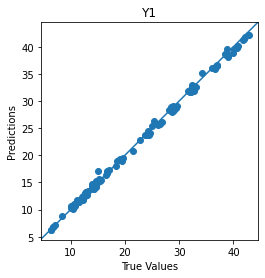

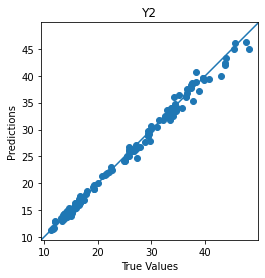

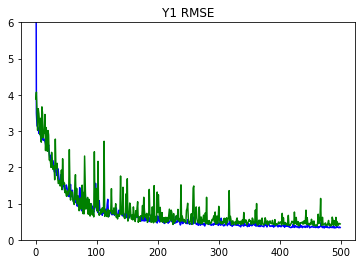

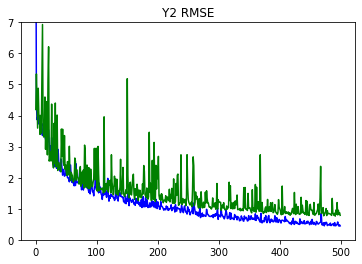

In [9]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)